In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata

# Preprocessing Data (Filter out unwanted columns and combining symptons into a list in merged_symptons)
CSV_Data = '../data/2021VAERSDATA.csv'
CSV_Symptoms = '../data/2021VAERSSYMPTOMS.csv'
CSV_Vax = "../data/2021VAERSVAX.csv" 

df_d = pd.read_csv(CSV_Data, names = ['VAERS_ID','RECVDATE','STATE','AGE_YRS','CAGE_YR','CAGE_MO','SEX','RPT_DATE','SYMPTOM_TEXT','DIED','DATEDIED','L_THREAT','ER_VISIT','HOSPITAL','HOSPDAYS','X_STAY','DISABLE','RECOVD','VAX_DATE','ONSET_DATE','NUMDAYS','LAB_DATA','V_ADMINBY','V_FUNDBY','OTHER_MEDS','CUR_ILL','HISTORY','PRIOR_VAX','SPLTTYPE','FORM_VERS','TODAYS_DATE','BIRTH_DEFECT','OFC_VISIT','ER_ED_VISIT','ALLERGIES'],error_bad_lines=False, index_col=False, dtype='unicode')
df = df_d.drop(['CAGE_YR','STATE', 'CAGE_MO', 'DIED','RPT_DATE','SYMPTOM_TEXT','DATEDIED','L_THREAT','ER_VISIT','HOSPITAL','HOSPDAYS','X_STAY','DISABLE','RECOVD','VAX_DATE','ONSET_DATE','NUMDAYS','LAB_DATA','V_ADMINBY','V_FUNDBY','OTHER_MEDS','SPLTTYPE','FORM_VERS','TODAYS_DATE','BIRTH_DEFECT','OFC_VISIT','ER_ED_VISIT'], axis=1)
df_s = pd.read_csv(CSV_Symptoms, names = ['VAERS_ID','SYMPTOM1','SYMPTOMVERSION1','SYMPTOM2','SYMPTOMVERSION2','SYMPTOM3','SYMPTOMVERSION3','SYMPTOM4','SYMPTOMVERSION4','SYMPTOM5','SYMPTOMVERSION5'],error_bad_lines=False, index_col=False, dtype='unicode')
df_s = df_s.drop(['SYMPTOMVERSION1','SYMPTOMVERSION2','SYMPTOMVERSION3','SYMPTOMVERSION4','SYMPTOMVERSION5'], axis = 1)
df_s['MERGED_SYMPTONS'] = df_s[df_s.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
df_s = df_s.drop(['VAERS_ID','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5'], axis = 1)
df = pd.concat([df,df_s], axis=1, join="inner")
df_v = pd.read_csv (CSV_Vax, names = ['VAERS_ID','VAX_TYPE','VAX_MANU','VAX_LOT','VAX_DOSE_SERIES','VAX_ROUTE','VAX_SITE','VAX_NAME'],error_bad_lines=False, index_col=False, dtype='unicode')
df_v = df_v.drop(['VAERS_ID','VAX_TYPE','VAX_LOT','VAX_ROUTE','VAX_SITE','VAX_NAME'], axis = 1)
df = pd.concat([df,df_v], axis=1, join="inner")

df = df.drop (df.index[0])
# Get symptons from age, sex, vac manu, vax dose series
df_as = df.drop(['RECVDATE','CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES'], axis = 1)
df_as

,VAERS_ID,AGE_YRS,SEX,MERGED_SYMPTONS,VAX_MANU,VAX_DOSE_SERIES
1,0916600,33.0,F,"Dysphagia,Epiglottitis",MODERNA,1
2,0916601,73.0,F,"Anxiety,Dyspnoea",MODERNA,1
3,0916602,23.0,F,"Chest discomfort,Dysphagia,Pain in extremity,V...",PFIZER\BIONTECH,1
4,0916603,58.0,F,"Dizziness,Fatigue,Mobility decreased",MODERNA,UNK
5,0916604,47.0,F,"Injection site erythema,Injection site pruritu...",MODERNA,1
...,...,...,...,...,...,...
146618,1272609,71.0,M,"Blood glucose increased,Fatigue,Headache,Type ...",PFIZER\BIONTECH,2
146619,1272610,41.0,F,"Injection site reaction,Thrombosis",PFIZER\BIONTECH,1
146620,1272636,24.0,F,Death,PFIZER\BIONTECH,2
146621,1272661,87.0,F,"Chest pain,Cough,Rash,Rash erythematous",PFIZER\BIONTECH,1


In [2]:
df_as.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146622 entries, 1 to 146622
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   VAERS_ID         146622 non-null  object
 1   AGE_YRS          131782 non-null  object
 2   SEX              146622 non-null  object
 3   MERGED_SYMPTONS  146622 non-null  object
 4   VAX_MANU         146622 non-null  object
 5   VAX_DOSE_SERIES  145639 non-null  object
dtypes: object(6)
memory usage: 7.8+ MB


In [3]:
# Get symptoms occurrences 

SYMPTOM_Dict ={}
num = 0
for x in df_as['MERGED_SYMPTONS']:
    string = ""
    for char in x:
        if(char == ","):
            if string in SYMPTOM_Dict :
                SYMPTOM_Dict[string] += 1
            else :
                SYMPTOM_Dict[string] = 1
            
            string = ""
        else:
            string += char
    if string in SYMPTOM_Dict :
        SYMPTOM_Dict[string] += 1
    else :
        SYMPTOM_Dict[string] = 1
    
sorted_dict = {}
sorted_keys = sorted(SYMPTOM_Dict, key=SYMPTOM_Dict.get, reverse = True)

for x in sorted_keys:
    sorted_dict[x] = SYMPTOM_Dict[x]

for x in sorted_dict:
    print(x,":",sorted_dict[x])


Headache : 24910
Chills : 20248
Pyrexia : 20152
Fatigue : 18756
Pain : 18481
Nausea : 13776
Dizziness : 11546
Pain in extremity : 10846
Injection site pain : 10387
Injection site erythema : 9595
Myalgia : 8398
Arthralgia : 7354
Injection site swelling : 7084
Pruritus : 6872
Injection site pruritus : 6628
Rash : 6041
Dyspnoea : 5324
Erythema : 5256
Injection site warmth : 5001
Vomiting : 4800
Asthenia : 4435
Diarrhoea : 3992
Urticaria : 3987
Paraesthesia : 3938
Lymphadenopathy : 3894
Malaise : 3635
Hyperhidrosis : 3361
Hypoaesthesia : 3253
Injection site rash : 3194
Feeling abnormal : 2867
Cough : 2590
Peripheral swelling : 2566
Chest discomfort : 2465
Heart rate increased : 2391
Skin warm : 2368
Tremor : 2276
Body temperature increased : 2209
Flushing : 2182
Feeling hot : 2160
Palpitations : 2106
Swelling : 2070
SARS-CoV-2 test negative : 2069
Rash erythematous : 2050
Chest pain : 2042
Back pain : 1990
SARS-CoV-2 test positive : 1937
Decreased appetite : 1879
Neck pain : 1863
Paraesthe

In [4]:
# add symptoms column to dataframe

symtoms = ["Headache","Chills","Pyrexia","Fatigue","Nausea","Dizziness","Injection site pain","Arthralgia","Pruritus","Rash","Dyspnoea","Erythema","Vomiting"]

for symtom in symtoms:
    l = []
    num = 0
    for x in df_as['MERGED_SYMPTONS']:
        string = ""
        check_contain = False
        for char in x:
            if(char == ","):
                if string == symtom:
                    check_contain = True
                string = ""
            else:
                string += char
        if string == symtom:
            check_contain = True
        num += 1
        if (check_contain):
            l.append(1)
        else:
            l.append(0)
    df_as.insert(len(df_as.columns),symtom,l,True)

df_asn = df_as.drop(["MERGED_SYMPTONS"],axis = 1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Remove rows where VAX_DOSE_SERIES is not 1 or 2
df_asn.drop(df_asn[(df_asn['VAX_DOSE_SERIES']!="1") & (df_asn['VAX_DOSE_SERIES']!="2")].index, inplace = True)
# Remove rows where VZX_MANU is not Moderna, Pfizer\Biotech, or Janssen
df_asn.drop(df_asn[(df_asn['VAX_MANU']!="MODERNA") & (df_asn['VAX_MANU']!="PFIZER\BIONTECH") &(df_asn['VAX_MANU']!="JANSSEN")].index, inplace = True)
# ID_encoded = le.fit_transform(np.ravel(df_as["VAERS_ID"]))
df_asn["VAERS_ID"] = df_asn["VAERS_ID"].astype(str).astype(int)
# Remove rows where Age is missing
df_asn.drop(df_asn[df_asn['AGE_YRS'].isna()].index, inplace = True)
df_asn["AGE_YRS"] = df_asn["AGE_YRS"].astype(str).astype(float)
Sex_encoded = le.fit_transform(np.ravel(df_asn["SEX"]))
df_asn["SEX"] = Sex_encoded
# 0 = JANSSEN, 1 = MODERNA, 2 = PFIZER\BIONTECH
VAX_MANU_encoded = le.fit_transform(np.ravel(df_asn["VAX_MANU"]))
df_asn["VAX_MANU"] = VAX_MANU_encoded
df_asn["VAX_DOSE_SERIES"] = df_asn["VAX_DOSE_SERIES"].astype(str).astype(int)

df_asn

,VAERS_ID,AGE_YRS,SEX,VAX_MANU,VAX_DOSE_SERIES,Headache,Chills,Pyrexia,Fatigue,Nausea,Dizziness,Injection site pain,Arthralgia,Pruritus,Rash,Dyspnoea,Erythema,Vomiting
1,916600,33.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,916601,73.0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,916602,23.0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,916604,47.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,916606,44.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146618,1272609,71.0,1,2,2,1,0,0,1,0,0,0,0,0,0,0,0,0
146619,1272610,41.0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
146620,1272636,24.0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0
146621,1272661,87.0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [6]:
df_asn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106713 entries, 1 to 146622
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   VAERS_ID             106713 non-null  int32  
 1   AGE_YRS              106713 non-null  float64
 2   SEX                  106713 non-null  int32  
 3   VAX_MANU             106713 non-null  int32  
 4   VAX_DOSE_SERIES      106713 non-null  int32  
 5   Headache             106713 non-null  int64  
 6   Chills               106713 non-null  int64  
 7   Pyrexia              106713 non-null  int64  
 8   Fatigue              106713 non-null  int64  
 9   Nausea               106713 non-null  int64  
 10  Dizziness            106713 non-null  int64  
 11  Injection site pain  106713 non-null  int64  
 12  Arthralgia           106713 non-null  int64  
 13  Pruritus             106713 non-null  int64  
 14  Rash                 106713 non-null  int64  
 15  Dyspnoea         

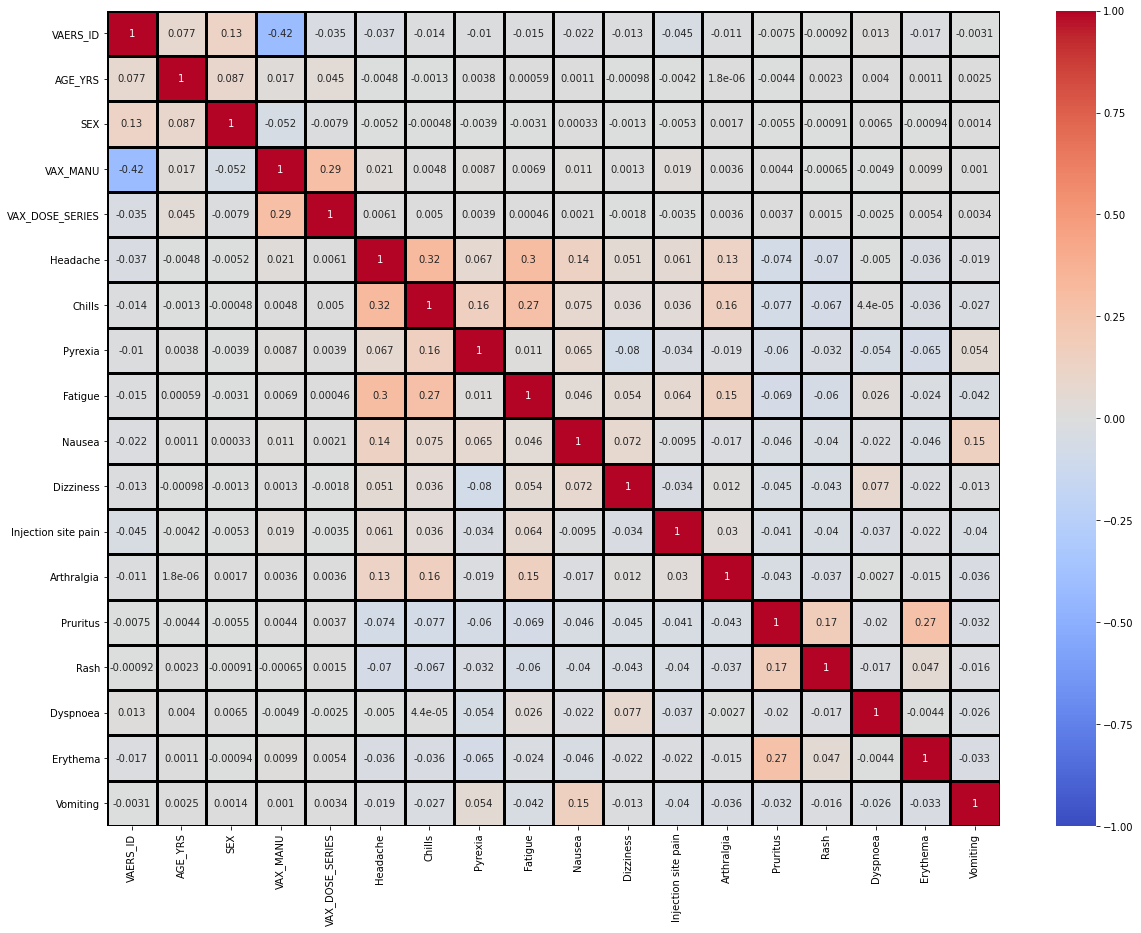

In [7]:
import seaborn as sns
import numpy as np
fig, ax = plt.subplots(figsize=(20,15))  
sns.heatmap(df_asn.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math 

df = shuffle(df_asn)

print("70% of data set used:", math.floor(df.shape[0]*0.7))
log = LogisticRegression()
X = df[['AGE_YRS','SEX','VAX_MANU','VAX_DOSE_SERIES']]

#print(log.predict(np.array([71,0,1, 1]).reshape(1, -1)))
Y_list = ['Headache','Chills','Pyrexia','Fatigue','Nausea','Dizziness','Injection site pain','Arthralgia','Pruritus','Rash','Dyspnoea','Erythema','Vomiting']


score = 0
num = 0 
for y in Y_list:   
    Y= df[y]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size =0.3)
    log.fit(x_train, y_train)
    print("Probability of", y, "happening: ",log.predict_proba(np.array([50,0,1, 1]).reshape(1, -1))[0][1])
    score += log.score(x_test, y_test)
    num += 1


# correct predictions / total number of data points
print("Accuracy of this prediction: ",score/num)

70% of data set used: 74699
Probability of Headache happening:  0.16662345991551944
Probability of Chills happening:  0.13497239098283853
Probability of Pyrexia happening:  0.13489966534639497
Probability of Fatigue happening:  0.1279667068087012
Probability of Nausea happening:  0.09401966248407802
Probability of Dizziness happening:  0.07954809661700203
Probability of Injection site pain happening:  0.07282402242563187
Probability of Arthralgia happening:  0.05033381922903131
Probability of Pruritus happening:  0.048989998262521324
Probability of Rash happening:  0.04234509609094059
Probability of Dyspnoea happening:  0.03513296883249934
Probability of Erythema happening:  0.036354432724749086
Probability of Vomiting happening:  0.031391746855266495
Accuracy of this prediction:  0.9180406649014135


In [9]:
# a person with headache after vaccine 
num = 0
for x in df_asn["Headache"]:
    
    if x == 1:
        print("AGE_YRS:",df_asn["AGE_YRS"][num])
        print("SEX:",df_asn["SEX"][num])
        print("VAX_MANU:",df_asn["VAX_MANU"][num])
        print("VAX_DOSE_SERIES:",df_asn["VAX_DOSE_SERIES"][num])
        break
    num += 1

AGE_YRS: 71.0
SEX: 0
VAX_MANU: 1
VAX_DOSE_SERIES: 1


In [11]:
# https://stackabuse.com/scikit-learn-save-and-restore-models/
import pickle

# Save to file in the current working directory
with open("symptoms.pkl", 'wb') as file:
    pickle.dump(log, file)
